<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install pymorphy2 --quiet

In [57]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
print('Python version:', sys.version)
print('Sklearn version:', sklearn.__version__)
print('Pymorphy2 version:', pymorphy2.__version__)

Python version: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Sklearn version: 1.0.2
Pymorphy2 version: 0.9.1


In [58]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
data.sample(10)

,comment,toxic
2109,Найти новость о посадке с двача вряд ли можно ...,0.0
1068,"В Украине 99,9 людей вообще не знают кто он та...",1.0
41,Ну давай разберём всё тобой написанное. Бляядь...,1.0
4668,"Ну в уставе написано же, что передвигаться по ...",0.0
9934,Срать на голову подданным.\n,1.0
12257,"Да однофигственно, что до 35, что после. Ну да...",0.0
3323,Хотела написать как за месяц без строгой диеты...,0.0
13197,есть такая штука как перемещаемый профиль все ...,0.0
9174,Кому как и мне интересно : сурьма это такой ме...,0.0
9942,Надоело нам волыны Маслом мазать день-деньской...,1.0


In [59]:
COL_TEXT='comment'
COL_LABEL='toxic'

In [60]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


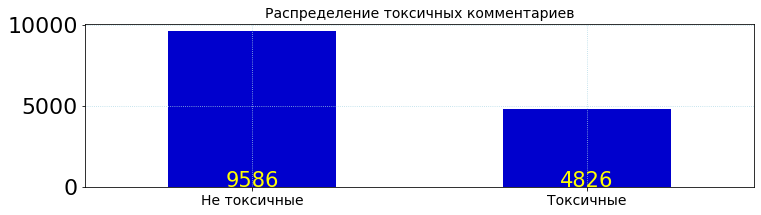

In [61]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [62]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [63]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [64]:
def clear_and_lemmatize_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [65]:
%%time
data['comment'] = data['comment'].apply(clear_and_lemmatize_text)

CPU times: user 1min 20s, sys: 209 ms, total: 1min 20s
Wall time: 1min 20s


In [66]:
data.sample(10)

,comment,toxic
9149,причём это на два одинаковый телефон использов...,0.0
9433,когда теоретически конечно на практика сопроти...,0.0
8092,женский гигиена это прокладка найса за правда ...,1.0
14126,наташа закукарекать заместо аврор,1.0
5792,предлагать пидарнуть трежда фаг оставить как е...,1.0
7550,автор что то темнить если проблема проявиться ...,0.0
12930,кг вес крышка тяжёлый по гост на видео средний,0.0
13068,я про то что политик там расстреливать пачка,1.0
5784,в ранний выпуск он быть более спокойный послед...,0.0
11869,ну спать пример менять провод ежемесячно специ...,0.0


In [67]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [68]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv')
df.sample(10)

,comment,toxic
2383,что ещё за адмирал колчак певец какой то что л...,1
10759,да весёлый чучело чем без он,1
3928,а на что он расчитывать хвататься за огромный ...,0
8326,как будто там кто то жд,0
9760,я тоже мел есть вкусный как правило круглый по...,0
1178,вы описать как надо эксплуатировать для долгий...,0
3721,в то время как выражение уровень цыган надо ст...,1
11023,наш трудовик ничуть не плохой метод схожий,0
13697,клетка это чат жопич начало го год когда поток...,0
4302,гы мы быть интересный есть компрессор винтовой...,0


**Взвесим tf-idf**

In [69]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [70]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [71]:
neutral_importance.sample(10) 

,word,idf
2825,личный,6.236338
6709,сузить,8.558725
4945,поступить,7.123641
2617,кофе,7.032669
970,вытекать,8.781869
736,воспитать,8.376404
783,всеобщий,8.558725
3899,опаздывать,8.781869
2949,масло,6.910067
3869,около,5.177731


In [72]:
toxic_importance.sample(10)

,word,idf
266,бь,8.095686
1084,заслуживать,7.872543
77,архитектура,7.872543
1817,наебывать,8.095686
1561,логика,6.997074
2799,предложение,7.536070
525,выражаться,7.872543
2019,но,3.571184
1035,закрывать,7.690221
1765,музыка,7.179395


**Разделение выборок, преобразование текстов**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [74]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [75]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [76]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [77]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 87.37 %


In [78]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 

True Negatives:  1832
False Positives:  70
False Negatives:  294
True Positives:  687


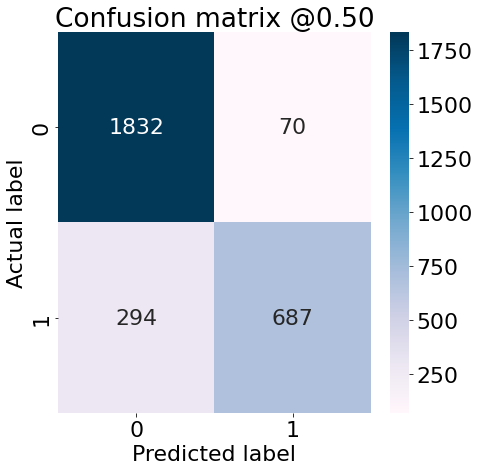

In [80]:
plot_cm(y_test, pred)

In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1902
           1       0.91      0.70      0.79       981

    accuracy                           0.87      2883
   macro avg       0.88      0.83      0.85      2883
weighted avg       0.88      0.87      0.87      2883



**Отобразим ROC - кривую**

LogisticRegression: ROC AUC=0.938


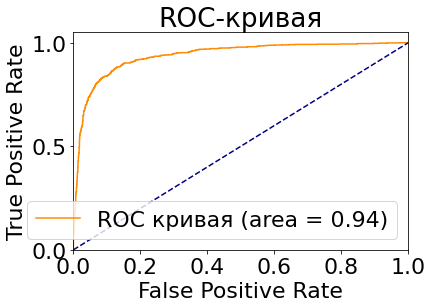

In [82]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = clf.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [83]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [84]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

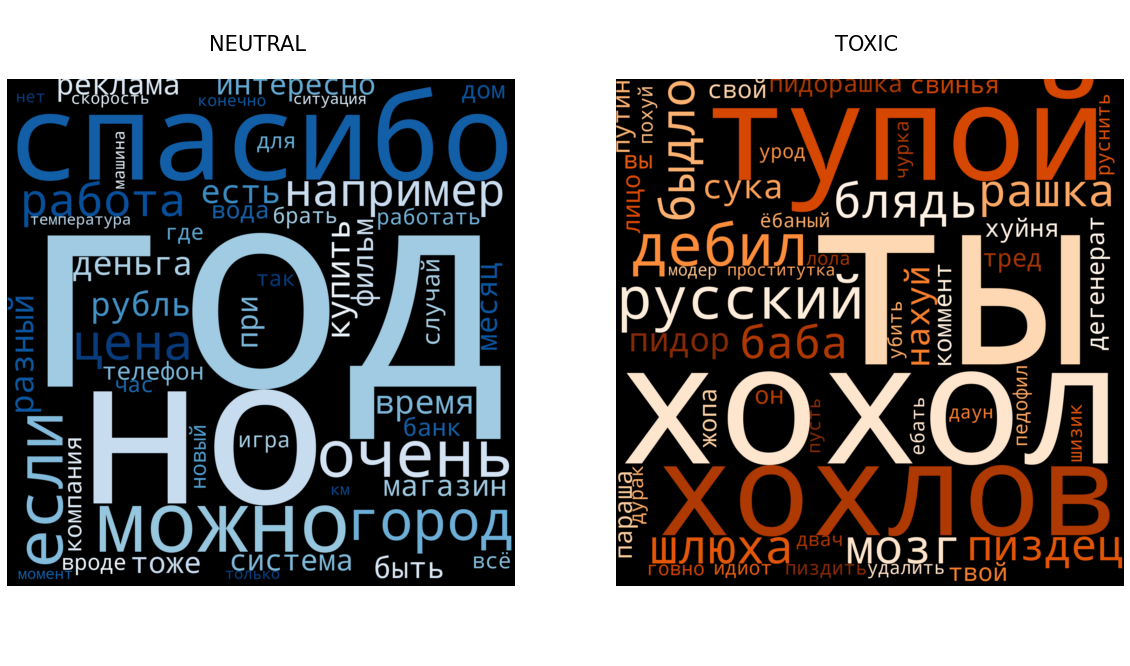

In [85]:
wordplot(toxic, neutral)